In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble, execute

# import basic plot tools
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector

import sys  
# use Constantin's utils =)
sys.path.append('../quantum-computing/python/src')
import state_preparation_util as spu

In [2]:
MIN_NUM = 0
MAX_NUM = 31

print("Quantum implementation of Bernstein–Vazirani algorithm for guessing game.")

Quantum implementation of Bernstein–Vazirani algorithm for guessing game.


In [3]:
print("Randomly picking a secret number between %d and %d...  " %(MIN_NUM, MAX_NUM))
# Generate a random integer
secret = random.randint(MIN_NUM, MAX_NUM)

print("(Secret number chosen is %d)" %(secret))

Randomly picking a secret number between 0 and 31...  
(Secret number chosen is 31)


In [4]:
secret_as_binary = format(secret, "b")
search_space_size = MAX_NUM.bit_length()
print("Size of search space is %d bits." %(search_space_size))

Size of search space is 5 bits.


In [5]:
# Pad secret with leading 0 as needed to ensure it has the same number of bit indices as the search space 
delta = search_space_size - len(secret_as_binary)
secret_as_binary = ("0" * delta) + secret_as_binary
print("(Secret number in binary is %s)" %(secret_as_binary))

(Secret number in binary is 11111)


     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     
q_4: 
     
q_5: 
     


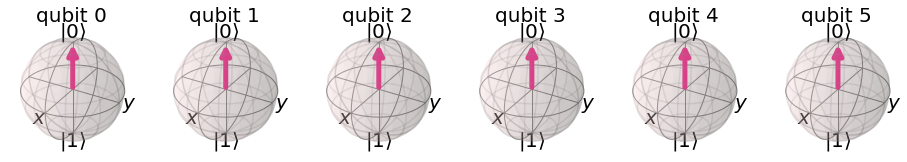

In [6]:
# We need a circuit with n qubits, plus one auxiliary qubit
bv_circuit = QuantumCircuit(search_space_size+1)
print(bv_circuit)

s = spu.run(bv_circuit)
plot_bloch_multivector(s)

               
q_0: ──────────
               
q_1: ──────────
               
q_2: ──────────
               
q_3: ──────────
               
q_4: ──────────
     ┌───┐┌───┐
q_5: ┤ X ├┤ H ├
     └───┘└───┘


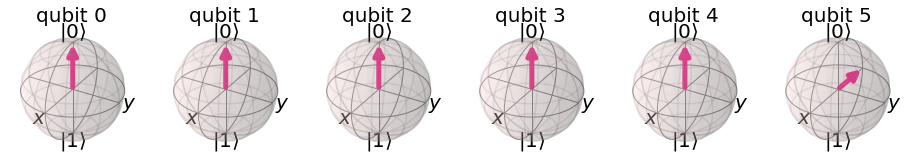

In [7]:
# put auxiliary in state |->
# bv_circuit.h(search_space_size)
# bv_circuit.z(search_space_size)

bv_circuit.x(search_space_size)
bv_circuit.h(search_space_size)
print(bv_circuit)

s = spu.run(bv_circuit)
plot_bloch_multivector(s)

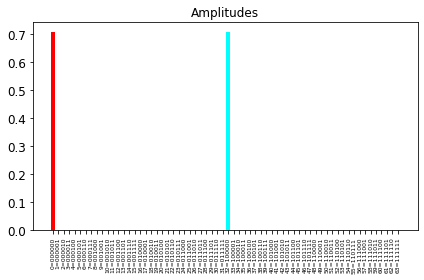

In [8]:
# Plot amplitudes
a = spu.state_to_ampls_dict(s)
spu.plot_bars(a, 'Amplitudes', '', '')

     ┌───┐     
q_0: ┤ H ├─────
     ├───┤     
q_1: ┤ H ├─────
     ├───┤     
q_2: ┤ H ├─────
     ├───┤     
q_3: ┤ H ├─────
     ├───┤     
q_4: ┤ H ├─────
     ├───┤┌───┐
q_5: ┤ X ├┤ H ├
     └───┘└───┘


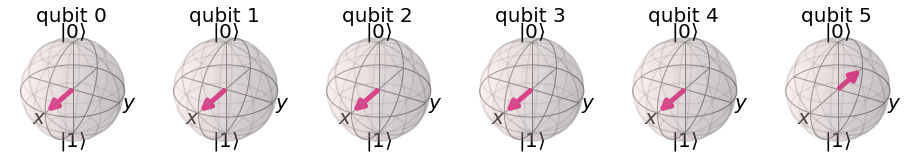

In [9]:
# Apply Hadamard gates before querying the oracle
for i in range(search_space_size):
    bv_circuit.h(i)

print(bv_circuit)

s = spu.run(bv_circuit)
plot_bloch_multivector(s)

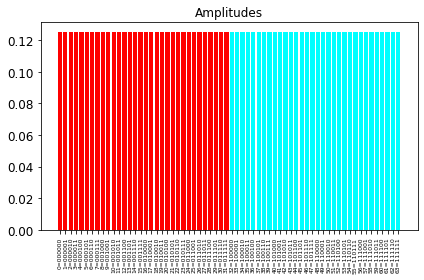

In [10]:
a = spu.state_to_ampls_dict(s)
spu.plot_bars(a, 'Amplitudes', '', '')

     ┌───┐      ░                           ░ 
q_0: ┤ H ├──────░───■───────────────────────░─
     ├───┤      ░   │                       ░ 
q_1: ┤ H ├──────░───┼────■──────────────────░─
     ├───┤      ░   │    │                  ░ 
q_2: ┤ H ├──────░───┼────┼────■─────────────░─
     ├───┤      ░   │    │    │             ░ 
q_3: ┤ H ├──────░───┼────┼────┼────■────────░─
     ├───┤      ░   │    │    │    │        ░ 
q_4: ┤ H ├──────░───┼────┼────┼────┼────■───░─
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐ ░ 
q_5: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░─
     └───┘└───┘ ░ └───┘└───┘└───┘└───┘└───┘ ░ 


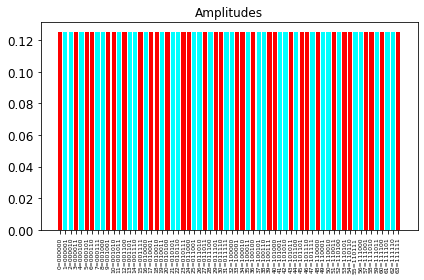

In [11]:
# Apply barrier
bv_circuit.barrier()

# reverse secret to fit qiskit's least significant bit (LSB) first ordering
lsb_first_secret = secret_as_binary[::-1]

# Apply the inner-product oracle
for q in range(search_space_size):
    if lsb_first_secret[q] == '1':
        bv_circuit.cx(q, search_space_size)
        
# Apply barrier 
bv_circuit.barrier()

print(bv_circuit)

s = spu.run(bv_circuit)
a = spu.state_to_ampls_dict(s)
spu.plot_bars(a, 'Amplitudes', '', '')

In [12]:
# Apply Hadamard gates after querying the oracle
for i in range(search_space_size):
    bv_circuit.h(i)

print(bv_circuit)

s = spu.run(bv_circuit)

     ┌───┐      ░                           ░ ┌───┐
q_0: ┤ H ├──────░───■───────────────────────░─┤ H ├
     ├───┤      ░   │                       ░ ├───┤
q_1: ┤ H ├──────░───┼────■──────────────────░─┤ H ├
     ├───┤      ░   │    │                  ░ ├───┤
q_2: ┤ H ├──────░───┼────┼────■─────────────░─┤ H ├
     ├───┤      ░   │    │    │             ░ ├───┤
q_3: ┤ H ├──────░───┼────┼────┼────■────────░─┤ H ├
     ├───┤      ░   │    │    │    │        ░ ├───┤
q_4: ┤ H ├──────░───┼────┼────┼────┼────■───░─┤ H ├
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘
q_5: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░──────
     └───┘└───┘ ░ └───┘└───┘└───┘└───┘└───┘ ░      


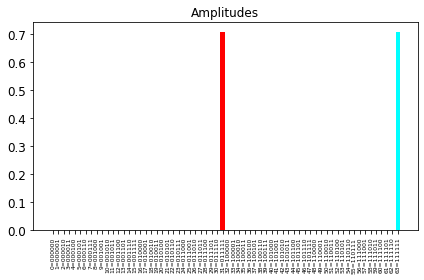

In [13]:
a = spu.state_to_ampls_dict(s)
spu.plot_bars(a, 'Amplitudes', '', '')

In [14]:
# bv_circuit.z(search_space_size)
# bv_circuit.h(search_space_size)

bv_circuit.h(search_space_size)
bv_circuit.x(search_space_size)

print(bv_circuit)

#s = spu.run(bv_circuit)
backend = Aer.get_backend('statevector_simulator')
job = execute(bv_circuit, backend)
results = job.result()
s = results.get_statevector()

     ┌───┐      ░                           ░ ┌───┐     
q_0: ┤ H ├──────░───■───────────────────────░─┤ H ├─────
     ├───┤      ░   │                       ░ ├───┤     
q_1: ┤ H ├──────░───┼────■──────────────────░─┤ H ├─────
     ├───┤      ░   │    │                  ░ ├───┤     
q_2: ┤ H ├──────░───┼────┼────■─────────────░─┤ H ├─────
     ├───┤      ░   │    │    │             ░ ├───┤     
q_3: ┤ H ├──────░───┼────┼────┼────■────────░─┤ H ├─────
     ├───┤      ░   │    │    │    │        ░ ├───┤     
q_4: ┤ H ├──────░───┼────┼────┼────┼────■───░─┤ H ├─────
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐ ░ ├───┤┌───┐
q_5: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░─┤ H ├┤ X ├
     └───┘└───┘ ░ └───┘└───┘└───┘└───┘└───┘ ░ └───┘└───┘


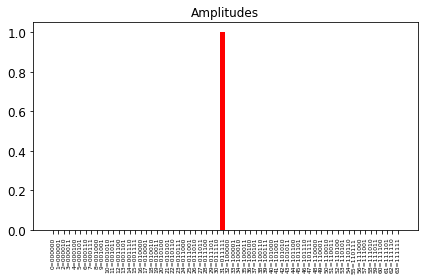

In [15]:
a = spu.state_to_ampls_dict(s)
spu.plot_bars(a, 'Amplitudes', '', '')

In [16]:
print("Secret number found is: ")
print(results.get_counts())

Secret number found is: 
{'011111': 1.0}
